In [1]:
import torch
import torchvision
import torch.nn as nn
from torchmetrics.detection import MeanAveragePrecision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import cv2
from pycocotools.coco import COCO
class CustomDataset(datasets.VisionDataset):
    def __init__(self, root, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms)
        self.coco = COCO(os.path.join(root, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(640, 640),
            # A.HorizontalFlip(p=0.3),
            # A.RandomBrightnessContrast(p=1),
            # A.Rotate(limit=14, p=0.5),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(640, 640), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
dataset_path = '../Only-axis-camera-images-2-coco/'
train_dir = dataset_path + 'train'
test_dir = dataset_path + 'test'
valid_dir = dataset_path + 'valid'

# Define datasets and dataloaders for train, test, and validation
train_dataset = CustomDataset(root=train_dir, transforms=get_transforms(True))
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

test_dataset = CustomDataset(root=test_dir, transforms=get_transforms())
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

valid_dataset = CustomDataset(root=valid_dir, transforms=get_transforms())
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
num_classes = 5 + 1 # Number of classes + background

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


## Calculate an inference

In [7]:
def inference(img, model, target=None, metrics=None, detection_threshold=0.70):
  '''
  Infernece of a single input image

  inputs:
    img: input-image as torch.tensor (shape: [C, H, W])
    model: model for infernce (torch.nn.Module)
    detection_threshold: Confidence-threshold for NMS (default=0.7)

  returns:
    boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
  '''
  model.eval()

  img = img.to(device)
  outputs = model([img])

  boxes = outputs[0]['boxes'].data.cpu().numpy()
  scores = outputs[0]['scores'].data.cpu().numpy()
  labels = outputs[0]['labels'].data.cpu().numpy()

  boxes = boxes[scores >= detection_threshold].astype(np.int32)
  labels = labels[scores >= detection_threshold]
  scores = scores[scores >= detection_threshold]
  if metrics is None and target is None:
    return boxes, scores, labels
  
  mAP = metrics(outputs, [target]) # mAP performance
  return boxes, scores, labels, mAP["map"]

## Plot an image

In [8]:
import matplotlib.patches as patches

def plot_image(img, boxes, labels, dataset, scores=None, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = 0
    if scores is not None:
      conf = scores[i]
    
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + (" " + str(int(100*conf)) + "%"),
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)
  plt.axis('off')
  plt.show()

## Plot images d'entraînement

In [11]:
import random

num_images = 5

coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
classes = [i[1]['name'] for i in categories.items()]

dataset = train_dataset

for _ in range(num_images, 2*num_images):
    x = random.randint(0, (dataset.__len__()-1))
    print(x)
    img, target = dataset.__getitem__(x)
    img = img.squeeze(0).cpu().permute(1,2,0).numpy()
    plot_image(img, target["boxes"], target["labels"], classes, save_path=None)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
28


NameError: name 'plot_image' is not defined

In [10]:
import random
random.seed(42)

coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
classes = [i[1]['name'] for i in categories.items()]
dataset = test_dataset 
for _ in iter(dataset):
  x = random.randint(0, (dataset.__len__()-1))
  img, target = dataset.__getitem__(x)
  img = img.to(device)

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
  #heckpoint_dir = f"/{OUTPUT_DIR}/epoch_5_model.pth"
  model_path = dataset_path + 'fine_tuned_rcnn_model.pth'
  checkpoint = torch.load(model_path, map_location=device)
  model.load_state_dict(checkpoint)

  boxes, scores, labels = inference(img, model)

  img = img.squeeze(0).cpu().permute(1,2,0).numpy()
  plot_image(img, boxes, labels, classes, scores, save_path=None)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


NameError: name 'device' is not defined

## Avec une métrique mAP

In [9]:
# Training step
def train_step(images, targets, model, criterion, optimizer, device):
    model.train() # set to training mode
    
    optimizer.zero_grad()

    images = list(image.to(device) for image in images)
    targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    # 2. compute loss
    #loss = criterion(losses, targets)

    losses.backward()
    
    optimizer.step()
    return loss_value


# Evaluation step
def eval_step(images, targets, model, metrics, device):
    model.eval() # set to evaluation mode
    with torch.no_grad(): # stop gradient computation
      images = list(image.to(device) for image in images)
      targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
      preds = model(images) # inference
      #targets = labels.softmax(1).argmax(1)
      metrics.update(preds, targets) # mAP performance
    metric = metrics.compute() 
    return np.array([metric["map"], metric["map_50"], metric["map_75"]])

In [19]:
import time
# train and validate cycle
def train_model(model, criterion, optimizer, scheduler, metrics, device, num_epochs=25):
    start = time.time()
    epoch_loss = []
    epoch_mAP = []
    #epoch_ious = []

    for epoch in range(num_epochs):
        # train loop
        running_loss = 0.0
        #running_accs = 0
        for images, labels in train_dataloader: # Iterate over data.
            loss = train_step(images, labels, model, criterion, optimizer, device)
            running_loss += loss
        scheduler.step() # decay learning rate
        train_epoch_loss = running_loss / len(train_dataset)
        epoch_loss.append(train_epoch_loss)

        # validation loop
        running_mAP = np.array([0, 0, 0])
        running_ious = 0
        for images, targets in valid_dataloader: # Iterate over data.
            mAP = eval_step(images, targets, model, metrics, device)
            running_mAP = running_mAP + mAP
            #running_ious += iou
        val_epoch_mAP = running_mAP / len(valid_dataset)
        #val_epoch_iou = running_ious / len(valid_dataset)
        epoch_mAP.append(val_epoch_mAP)
        #epoch_ious.append(val_epoch_iou)

        #print('Epoch {}/{} >> TRAIN Loss: {:.4f} | VAL IoU: {:.4f} Acc: {:.4f}'.format(
        #        epoch, num_epochs-1, train_epoch_loss, val_epoch_iou, val_epoch_acc))
        

        print('Epoch {}/{} LR: {:.4f} >> TRAIN Loss: {:.4f} | VAL mAP: {:.4f} VAL mAP50: {:.4f} VAL mAP75: {:.4f}'.format(
                epoch, num_epochs-1, optimizer.param_groups[0]['lr'], train_epoch_loss, val_epoch_mAP[0], val_epoch_mAP[1], val_epoch_mAP[2]))
        print('-' * 10)

    # Reports
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    fig = plt.figure()

    ax = fig.add_subplot(131)
    intervals = np.arange(len(epoch_loss))
    ax.plot(intervals, epoch_loss)
    ax.set_xlabel("epochs")
    ax.set_ylabel("Detection loss")

    ax = fig.add_subplot(132)
    intervals = np.arange(len(epoch_mAP))
    ax.plot(intervals, epoch_mAP)
    ax.set_xlabel("epochs")
    ax.set_ylabel("validation mAP")

    # ax = fig.add_subplot(133)
    # intervals = np.arange(len(epoch_ious))
    # ax.plot(intervals, epoch_ious)
    # ax.set_xlabel("epochs")
    # ax.set_ylabel("validation IoU")

    now = datetime.now()
    today_filename = "rcnn_resnetv2_"+now.strftime("%H-%d-%m-%Y")+".png"
    plt.savefig(today_filename)

    #print("Evaluation Accuracy = {} and IoU = {}".format(epoch_accs[-1], epoch_ious[-1]))
    print("Evaluation mAP = {}".format(epoch_mAP[-1]))
    # clear GPU cache memory
    torch.cuda.empty_cache()
    return model

In [11]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
num_classes = 5 + 1 # Number of classes + background

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Epoch 0/39 LR: 0.0500 >> TRAIN Loss: 0.4223 | VAL mAP: 0.2111 VAL mAP50: 0.4067 VAL mAP75: 0.1940
----------
Epoch 1/39 LR: 0.0500 >> TRAIN Loss: 0.2913 | VAL mAP: 0.2132 VAL mAP50: 0.4077 VAL mAP75: 0.1965
----------
Epoch 2/39 LR: 0.0500 >> TRAIN Loss: 0.2298 | VAL mAP: 0.2239 VAL mAP50: 0.4132 VAL mAP75: 0.2166
----------
Epoch 3/39 LR: 0.0500 >> TRAIN Loss: 0.1893 | VAL mAP: 0.2377 VAL mAP50: 0.4213 VAL mAP75: 0.2496
----------
Epoch 4/39 LR: 0.0500 >> TRAIN Loss: 0.1724 | VAL mAP: 0.2457 VAL mAP50: 0.4257 VAL mAP75: 0.2649
----------
Epoch 5/39 LR: 0.0500 >> TRAIN Loss: 0.1472 | VAL mAP: 0.2476 VAL mAP50: 0.4277 VAL mAP75: 0.2681
----------
Epoch 6/39 LR: 0.0500 >> TRAIN Loss: 0.1357 | VAL mAP: 0.2488 VAL mAP50: 0.4295 VAL mAP75: 0.2689
----------
Epoch 7/39 LR: 0.0500 >> TRAIN Loss: 0.1227 | VAL mAP: 0.2535 VAL mAP50: 0.4298 VAL mAP75: 0.2798
----------
Epoch 8/39 LR: 0.0500 >> TRAIN Loss: 0.1098 |

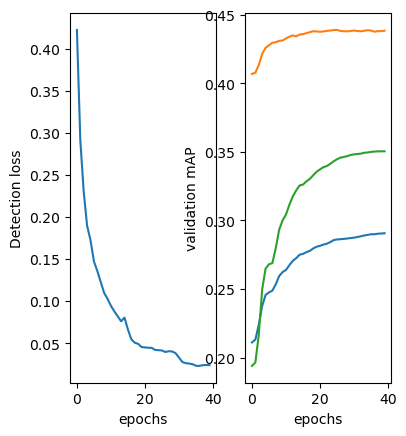

In [21]:
# learning rate
LEARNING_RATE = 0.05

# resource allocation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model  = model.to(device)
# metrics function
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
classes = [i[1]['name'] for i in categories.items()]
metrics =  MeanAveragePrecision(iou_type="bbox")
metrics = metrics.to(device)

# SGD optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, nesterov=True, weight_decay=1e-4)

# learning rate decay scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7)

# loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

trained_model = train_model(model, criterion, optimizer, scheduler, metrics, device, num_epochs=40)

In [22]:
# Save the trained model
save_model_path = dataset_path + 'only_axis_faster_rcnn_resnetv2_model.pth'
torch.save(model.state_dict(), save_model_path)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
mAP: 0.7457


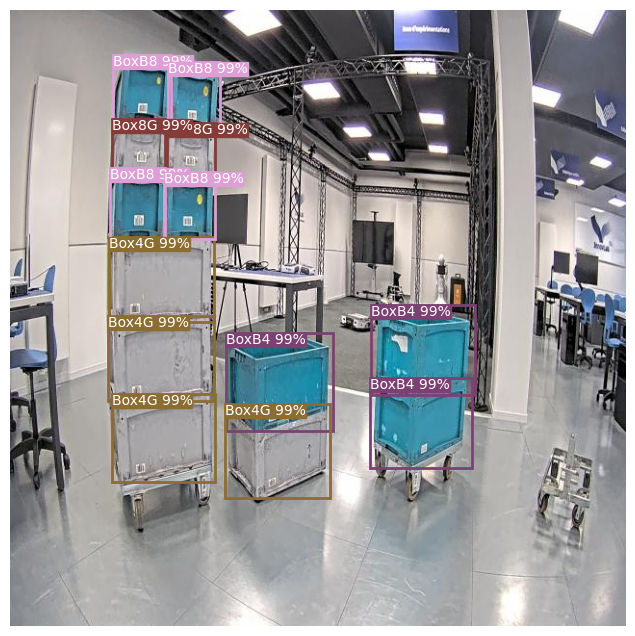

mAP: 0.6631


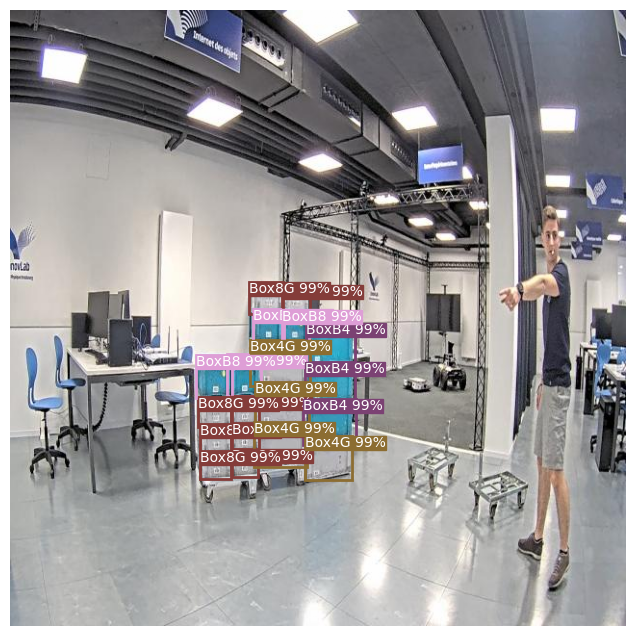

mAP: 0.6631


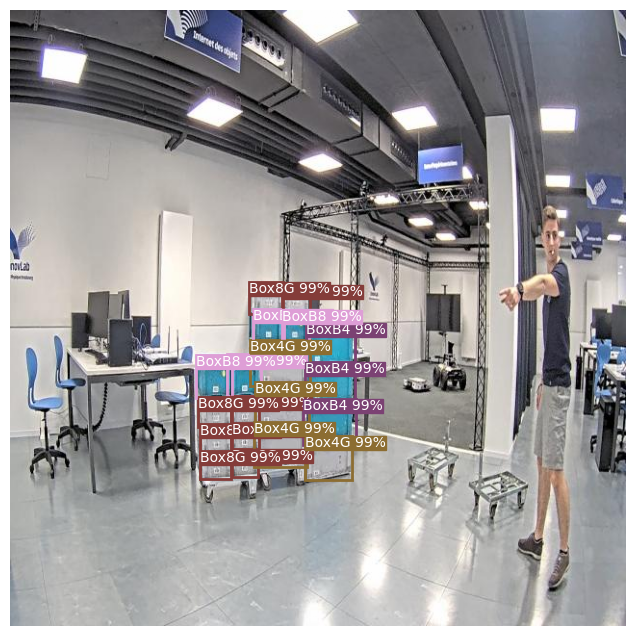

mAP: 0.8245


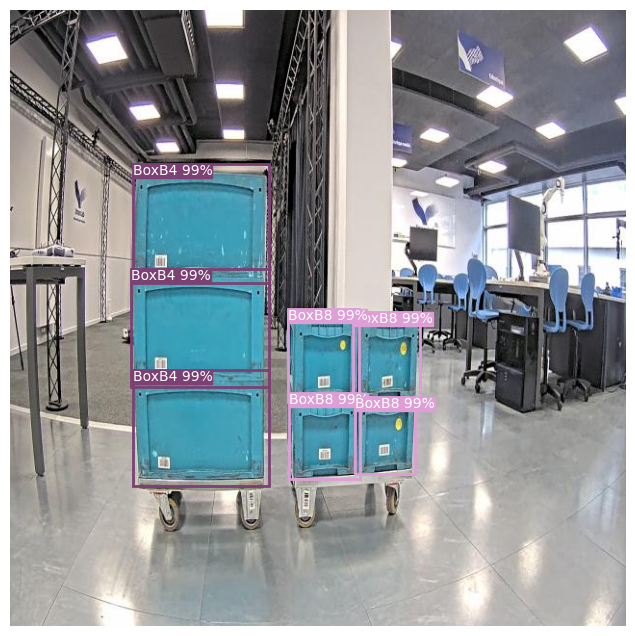

mAP: 0.8089


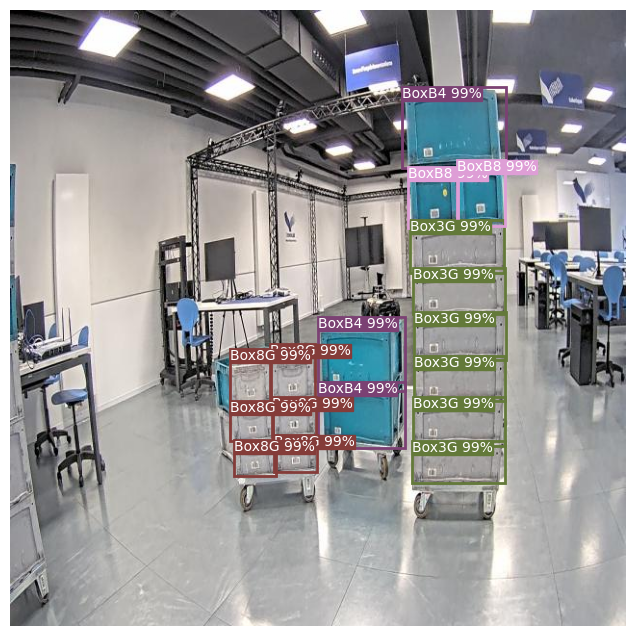

mAP: 0.8459


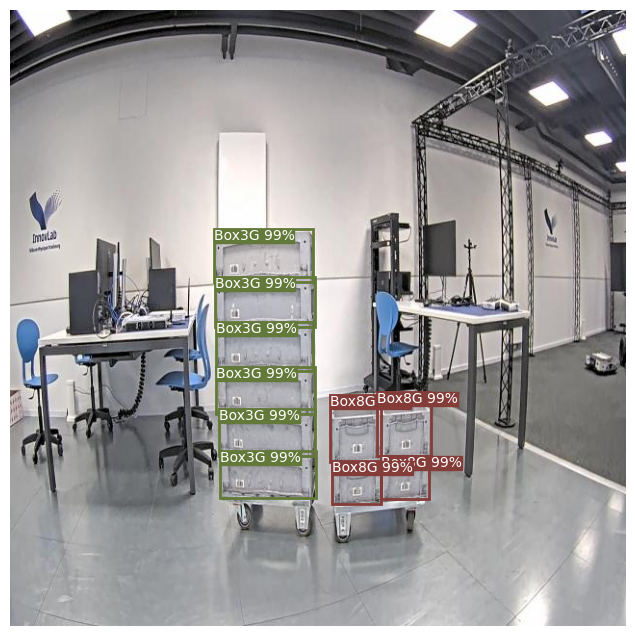

mAP: 0.7457


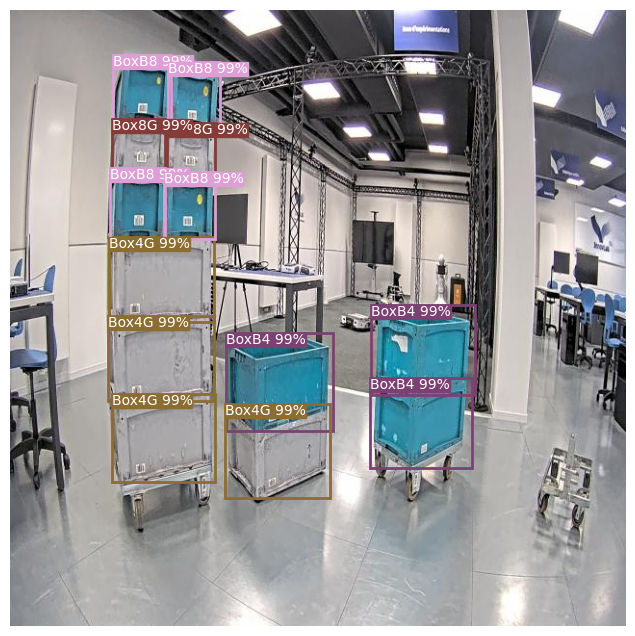

mAP: 0.8245


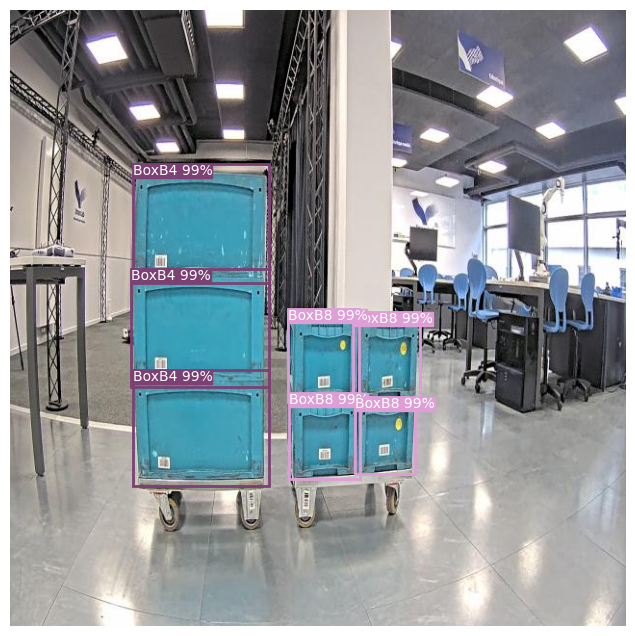

mAP: 0.8459


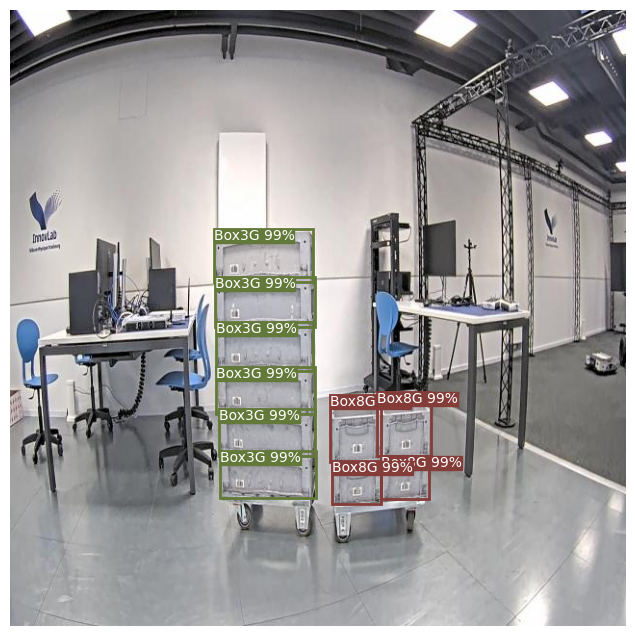

mAP: 0.7457


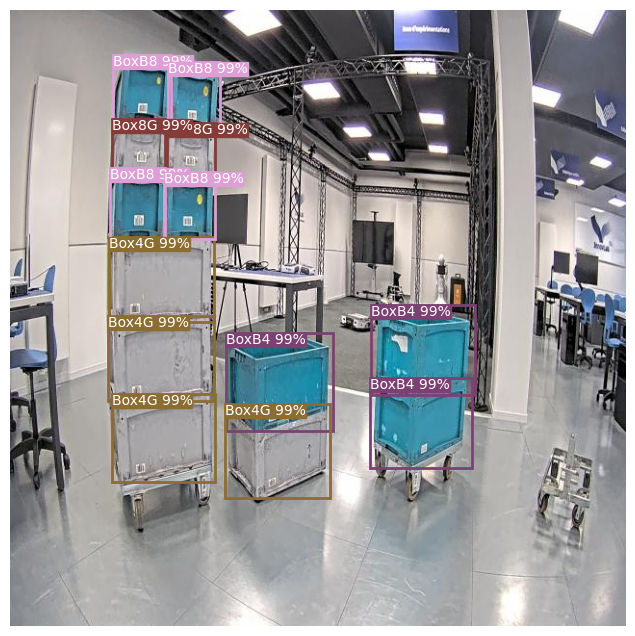

In [25]:
import random
random.seed(42)
#device = "cpu"

coco = COCO(os.path.join(dataset_path, "test", "_annotations.coco.json"))
categories = coco.cats
classes = [i[1]['name'] for i in categories.items()]
dataset = test_dataset 
for _ in iter(dataset):
  x = random.randint(0, (dataset.__len__()-1))
  img, target = dataset.__getitem__(x)
  img = img.to(device)
  target = {k:v.to(device) for k, v in target.items()}
  # Load last checkpoint
  #checkpoint_dir = save_model_path
  #model_path = dataset_path + 'fine_tuned_rcnn_model.pth'
  checkpoint = torch.load(save_model_path, map_location=device)
  model.load_state_dict(checkpoint)
  model = model.to(device)

  boxes, scores, labels, mAP = inference(img, model, target=target, metrics=metrics)
  print("mAP: {:.4f}".format(mAP))
  img = img.squeeze(0).cpu().permute(1,2,0).numpy()
  plot_image(img, boxes, labels, classes, scores, save_path=None)

## Sur des images hors du jeu de test (sans annotations)

mAP: 0.7457


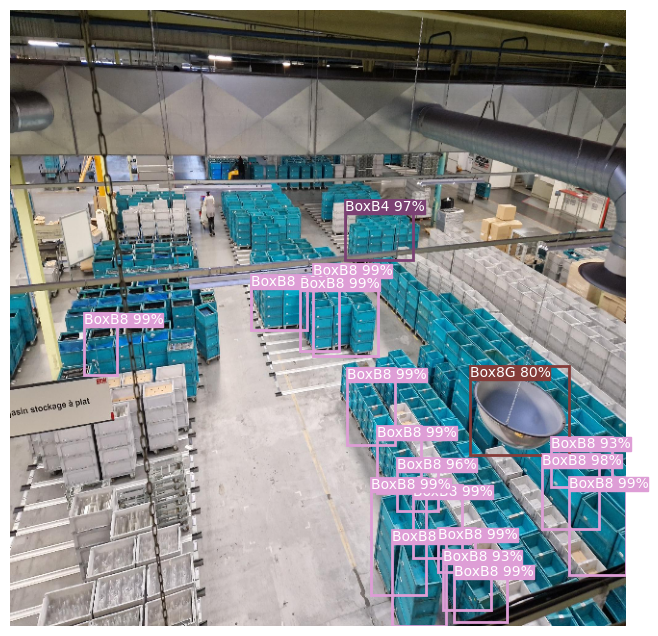

In [26]:
import cv2
import torch

device = "cpu"

img = cv2.imread("/home/nicolastovantrang/Desktop/sew/data/good_highground_images/1000017731.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

transform = A.Compose([
            A.Resize(640, 640), # our input size can be 600px
            ToTensorV2()
])
transformed_img = transform(image=img)
img = transformed_img["image"]
img = img.div(255)
img = img.to(device)

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
  #checkpoint_dir = f"/{OUTPUT_DIR}/epoch_5_model.pth"
#model_path = "../Box-Counting-5/fine_tuned_rcnn_model.pth"
checkpoint = torch.load(save_model_path, map_location=device)
model.load_state_dict(checkpoint)

boxes, scores, labels = inference(img, model)
print("mAP: {:.4f}".format(mAP))

img = img.squeeze(0).cpu().permute(1,2,0).numpy()
plot_image(img, boxes, labels, classes, scores, save_path=None)